<h1>Затяжные пожары</h1>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix


SQL запрос:

SELECT FR2021.F0, FR2021.F1, FR2021.F5, FR2021.F6, т08F12_Объекты.ОбъектТактика AS F12, FR2021.F14, FR2021.F15, FR2021.F16, FR2021.F26, FR2021.F63, FR2021.F64, FR2021.F157, FR2021.F158, FR2021.F69, FR2021.F70, FR2021.F159, FR2021.F160, FR2021.F71, т17F72_74_УслРазвПожара.F72_74гр AS F72, FR2021.F83, FR2021.F84, FR2021.F85, FR2021.F86, FR2021.F87, FR2021.F88, FR2021.F89, FR2021.F90, FR2021.F91, FR2021.F92, FR2021.F93, FR2021.F99, [F43]+[F44] AS S
FROM т17F72_74_УслРазвПожара INNER JOIN (т08F12_Объекты INNER JOIN FR2021 ON т08F12_Объекты.F12 = FR2021.F12) ON т17F72_74_УслРазвПожара.F72_74 = FR2021.F72
WHERE (((FR2021.F1)=1144 Or (FR2021.F1)=1146 Or (FR2021.F1)=1176) AND ((FR2021.F4)=0));


Словарь:
during fire extinguishing - время тушения пожара

In [2]:
class FireLong():
    # Расход стволов:
    flw = {0: 0, 1: 7, 2: 3.5, 3: 20, 4: 6,
           5: 0, 6: 3.5, 7: 3.5, 8: 3.5, 9: 3.5}
    # Количество дней в месяцах
    dm = {1: 31, 2: 28, 3: 31, 4: 30, 5: 31, 6: 30,
          7: 31, 8: 31, 9: 30, 10: 31, 11: 20, 12: 31}
    # Количество дней от начала года до заданного месяца
    dms = {1: 0, 2: 31, 3: 59, 4: 90, 5: 120, 6: 151, 7: 181,
           8: 212, 9: 243, 10: 273, 11: 304, 12: 334}
    

    def leap_year(self, y):
        # Количество дней в году
        if (y % 4 == 0 and y % 100 != 0) or y % 400 == 0:
            return 366
        else:
            return 365

    def day_month(self, m, y):
        # Високосный год
        if self.leap_year(y) == 366 and m > 1:
            leap = 1
        else:
            leap = 0

        if m > 0 and m < 13:
            return self.dms[m] + leap
        else:
            return 0

    def BeetweenTime(self, d_start, hs, ms, d_finish, hf, mf):
        '''Количество минут в интевале между метками, заданными
        датой и временем
        '''
        day_st = d_start.split()[0].split('.')
        day_fn = d_finish.split()[0].split('.')

        dst, dfn = int(day_st[0]), int(day_fn[0])  # Количество дней
        # Количество дней от января до месяца
        mst, mfn = int(day_st[1]), int(day_fn[1])
        yst, yfn = int(day_st[2]), int(day_fn[2])

        # Минуты
        m = int(eval(f'60*({hf}-{hs})+{mf}-{ms}'))

        d = 0
        if day_st != day_fn:  # Вычисление разности в днях между месяцами
            d = dfn + self.day_month(mfn, yfn) - dst - self.day_month(mst, yst)

        if yst != yfn:  # Вычисление разности в днях между годами
            d += 365 * (yfn - yst)

        res = d*1440 + m

        return res

    def decade(self, data):  # Вычисление номера декады года
        d1 = data.split('.')
        if len(d1[2]) > 4:
            d1[2] = d1[2][:4]

        d, m, y = int(d1[0]), int(d1[1]), int(d1[2])
        d += self.day_month(m, y)
        return (d-1) // 10 + 1

    def flow(self, s1, s2, s3, n1, n2, n3):
        # Передача параметров функции по раздельности выполняется быстрее,
        # чем если передавать срез строки фрейма
        ''' Определение суммарного расхода воды
        0 Не указан - 0
        1 Ствол А - 7 л/с
        2 Ствол Б - 3.5 л/с
        3 Ствол лафетный - 20 л/с
        4 Ствол пенный - 6 л/с
        5 Ствол порошковый 0
        6 Ствол водопенный - 6 л/с 
        7 Ствол высокого давления - 3.5 л/с
        8 Ствол ручной - универсальный - 3.5 л/с
        9 Ствол ручной - комбинированный - 3.5 л/с
        '''
        return self.flw[s1]*n1 + self.flw[s2]*n2 + self.flw[s3]*n3
    
    def jitter(self, data, stdev):
        '''Дрожжание точек - добавление разброса для координат'''
        N = len(data)
        return data + np.random.randn(N) * stdev

f = FireLong()

In [6]:
# Начальная выборка 26389х203
# После отбора осталось 30 колонок
d1 = pd.read_csv('long.csv', encoding='1251', index_col='F0')  # Кодировка Windows-1251

# Понижение разрядности float -> integer
cols = list(d1.select_dtypes(include='float').columns)
d1[cols] = d1[cols].astype(int)

# Время занятости - интервал: получение вызова - ликвидация последствий
d1['Busy'] = [f.BeetweenTime(d1.F5.loc[i], d1.F63.loc[i], d1.F64.loc[i],
                             d1.F71.loc[i], d1.F159.loc[i], d1.F160.loc[i])
              for i in d1.index]
mask = d1.Busy < 10  # Все некорректные значения заменяются на 10
d1.loc[mask, 'Busy'] = 10

# Время тушения - интервал: подача 1-го ствола - ликвидация открытого горения
d1['Exting'] = [f.BeetweenTime(d1.F5.loc[i], d1.F157.loc[i], d1.F158.loc[i],
                             d1.F71.loc[i], d1.F69.loc[i], d1.F70.loc[i])
              for i in d1.index]
mask = d1.Exting < 3  # Все некорректные значения заменяются на 3
d1.loc[mask, 'Exting'] = 3

mask = d1.Busy < d1.Exting  # Время тушения превышает время занятости
d1.loc[mask, 'Exting'] = d1.Exting - 1440

mask = d1.Exting < 3
d1.loc[mask, 'Exting'] = 3

# Декады и месяцы
# d1['Decade'] = [f.decade(d1.F5.loc[i]) for i in range(d1.shape[0])]
d1['Month'] = pd.DatetimeIndex(d1.F5).month

# Удаление колонок даты и времени - больше не нужны
cols = 'F5 F63 F64 F157 F158 F69 F70 F159 F160 F71'.split()
d1 = d1.drop(columns=cols)

# Населенные пункты: 1 - города; 0 - сельская местность
mask = d1.F6 == 2  # Поселки городского типа  -> Город
d1.loc[mask, 'F6'] = 1
mask = d1.F6 != 1  # Все остальное село == 0
d1.loc[mask, 'F6'] = 0

# F12 - Объект пожара - Тактика2
'''
0	Не классифицировано
1	Производственные здания
2	Жилые здания и постройки
3	Общественные здания
4	Складские здания
5	Транспорт
6	Открытые территории
9	Прочие
'''

# F12 - Объект пожара - Тактика
'''
0	Не классифицировано
1	Здания
2	Склады
3	Транспорт
8	Открытые территории
9	Прочие'''

# F14 - этажность здания; F15 - этаж пожара 
'''  
90	Цокольный - с 2009 года код вместо 90 стал 900 и т.д.
91	Подвальный
92	Мансардный
93	Технический
94	Подземный 1
95	Подземный 2
96	Подземный 3
97	Подземный 4
98	Чердачный'''

# Условия развития пожара до крупных размеров
'''
1	Позднее обнаружение пожара (более 10 мин.)
2	Позднее сообщение о пожаре (более 5 мин.) в пожарную охрану
3	Отсутствие мер по борьбе с пожаром до прибытия подразделений пожарной охраны
4	Позднее прибытие подразделений пожарной охраны к месту пожара
5	Поздняя подача огнетушащих средств в очаг пожара подразделениями пожарной охраны 
6	Форс-мажорные обстоятельства
7	Недостатки в организации пожаротушения
8	Прочие условия
9	Пожары по заявлению'''

mask = d1.F15.isin([900, 901, 904])
d1.loc[mask, 'F15'] = -1
mask = d1.F15.isin([905, 906, 907])
d1.loc[mask, 'F15'] = -1 * d1.F15 + 903
mask = d1.F15.isin([902, 903, 908])
d1.loc[mask, 'F15'] = d1.F14

# F16 - степень огнестойкости
mask = d1.F16 == 6
d1.loc[mask, 'F16'] = 0

# Общее количество пожарной техники
cols = 'F83 F84 F85 F86 F87'.split()
d1['Car'] = d1[cols].sum(axis=1)
d1 = d1.drop(columns=cols)

# Общее количество ствол
d1['Nozzle'] = d1[['F91', 'F92', 'F93']].sum(axis=1)
mask = d1.Nozzle == 0  # Стволы не подавались
d1.loc[mask, 'Exting'] = 0  # Расход воды = 0

# Общий расход воды, л/с
d1['Flow'] = [f.flow(d1.F88.loc[i], d1.F89.loc[i], d1.F90.loc[i],
                     d1.F91.loc[i], d1.F92.loc[i], d1.F93.loc[i])
              for i in d1.index]

d1 = d1.drop(columns=['F88', 'F89', 'F90', 'F91', 'F92', 'F93'])

# F99 - использование ГДЗС
mask = d1.F99 > 0
d1.loc[mask, 'F99'] = 1

print('Очищенная выборка')
d1.head()

Очищенная выборка


,F1,F6,F12,F14,F15,F16,F26,F72,F99,S,F149,Busy,Exting,Month,Car,Nozzle,Flow
F0,,,,,,,,,,,,,,,,,
1541656,1144,1,1,1,1,5,4,1,0,20,частный дом,76,24,1,2,2,7.0
1541657,1144,1,1,1,1,3,3,1,0,3,частный гараж,269,46,1,1,2,7.0
1541658,1144,1,1,1,1,3,2,1,0,43,гараж,152,42,1,1,2,7.0
1541659,1144,1,8,0,0,0,2,0,0,10,мусор на открытой территории,25,10,4,1,1,3.5
1541660,1144,1,1,1,1,3,2,0,1,20,"Ремонтный бокс ООО ""Спецавтострой""",37,12,4,8,2,7.0


In [7]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26389 entries, 1541656 to 1864687
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      26389 non-null  int32  
 1   F6      26389 non-null  int32  
 2   F12     26389 non-null  int64  
 3   F14     26389 non-null  int32  
 4   F15     26389 non-null  int32  
 5   F16     26389 non-null  int32  
 6   F26     26389 non-null  int32  
 7   F72     26389 non-null  int64  
 8   F99     26389 non-null  int32  
 9   S       26389 non-null  int32  
 10  F149    26389 non-null  object 
 11  Busy    26389 non-null  int64  
 12  Exting  26389 non-null  int64  
 13  Month   26389 non-null  int64  
 14  Car     26389 non-null  int64  
 15  Nozzle  26389 non-null  int64  
 16  Flow    26389 non-null  float64
dtypes: float64(1), int32(8), int64(7), object(1)
memory usage: 3.8+ MB


In [75]:
# Загрузка очищенных данных
d1 = pd.read_csv('Long_R2.csv', index_col='F0')  # , sep=';', decimal=','
d1.head()

,F1,F6,F12,F14,F15,F16,F26,F72,F99,S,Busy,Exting,Month,Car,Nozzle,Flow,Long
F0,,,,,,,,,,,,,,,,,
1541656,1144,1,1,1,1,5,4,1,0,20,76,24,1,2,2,7.0,0
1541657,1144,1,1,1,1,3,3,1,0,3,269,46,1,1,2,7.0,0
1541658,1144,1,1,1,1,3,2,1,0,43,152,42,1,1,2,7.0,0
1541659,1144,1,8,0,0,0,2,0,0,10,25,10,4,1,1,3.5,0
1859733,1176,1,1,1,1,2,1,8,1,160,43,28,9,4,8,28.0,0


<h3>Предварительная оценка распределений</h3>

In [19]:
# Иформация о выборке
d1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26389 entries, 1541656 to 1864687
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      26389 non-null  int64  
 1   F6      26389 non-null  int64  
 2   F12     26389 non-null  int64  
 3   F14     26389 non-null  int64  
 4   F15     26389 non-null  int64  
 5   F16     26389 non-null  int64  
 6   F26     26389 non-null  int64  
 7   F72     26389 non-null  int64  
 8   F99     26389 non-null  int64  
 9   S       26389 non-null  int64  
 10  Busy    26389 non-null  int64  
 11  Exting  26389 non-null  int64  
 12  Month   26389 non-null  int64  
 13  Car     26389 non-null  int64  
 14  Nozzle  26389 non-null  int64  
 15  Flow    26389 non-null  float64
 16  Long    26389 non-null  int64  
dtypes: float64(1), int64(16)
memory usage: 3.6 MB


F1 - Субъект РФ<br>
F6 - Вид населенного пункта<br>
F12 - Объект пожара<br>
F14 - Этажность здания<br>
F15 - Этаж, на котором возник пожар<br>
F16 - Степень огнестойкости<br>
F26 - Расстояние до пожарной части<br>
F72 - Условия, способств. развитию пожара<br>
F99 - Использование СИЗОД<br>
S - Площадь пожара<br>
Busy - Время занятости на пожаре<br>
Exting - Время подачи стволов<br>
Month - Номер месяца года<br>
Car - Общее количество техники, ед.<br>
Nozzle - Общее количество стволов, ед.<br>
Flow - Расход воды на тушени, л/с<br>
Long - Признак затяжного пожара (0,1)<br>

columns=['F1','F12','F193','F72']

In [17]:
# Количество пожаров по регионам
print('Количество пожаров по регионам:\n', d1.groupby('F1').size())
print('Количество автомобилей по регионам:\n', d1.groupby('F1')['Car'].sum())

Количество пожаров по регионам:
 F1
1144      877
1146    20520
1176     4992
dtype: int64
Количество автомобилей по регионам:
 F1
1144     1472
1146    38442
1176     7471
Name: Car, dtype: int64


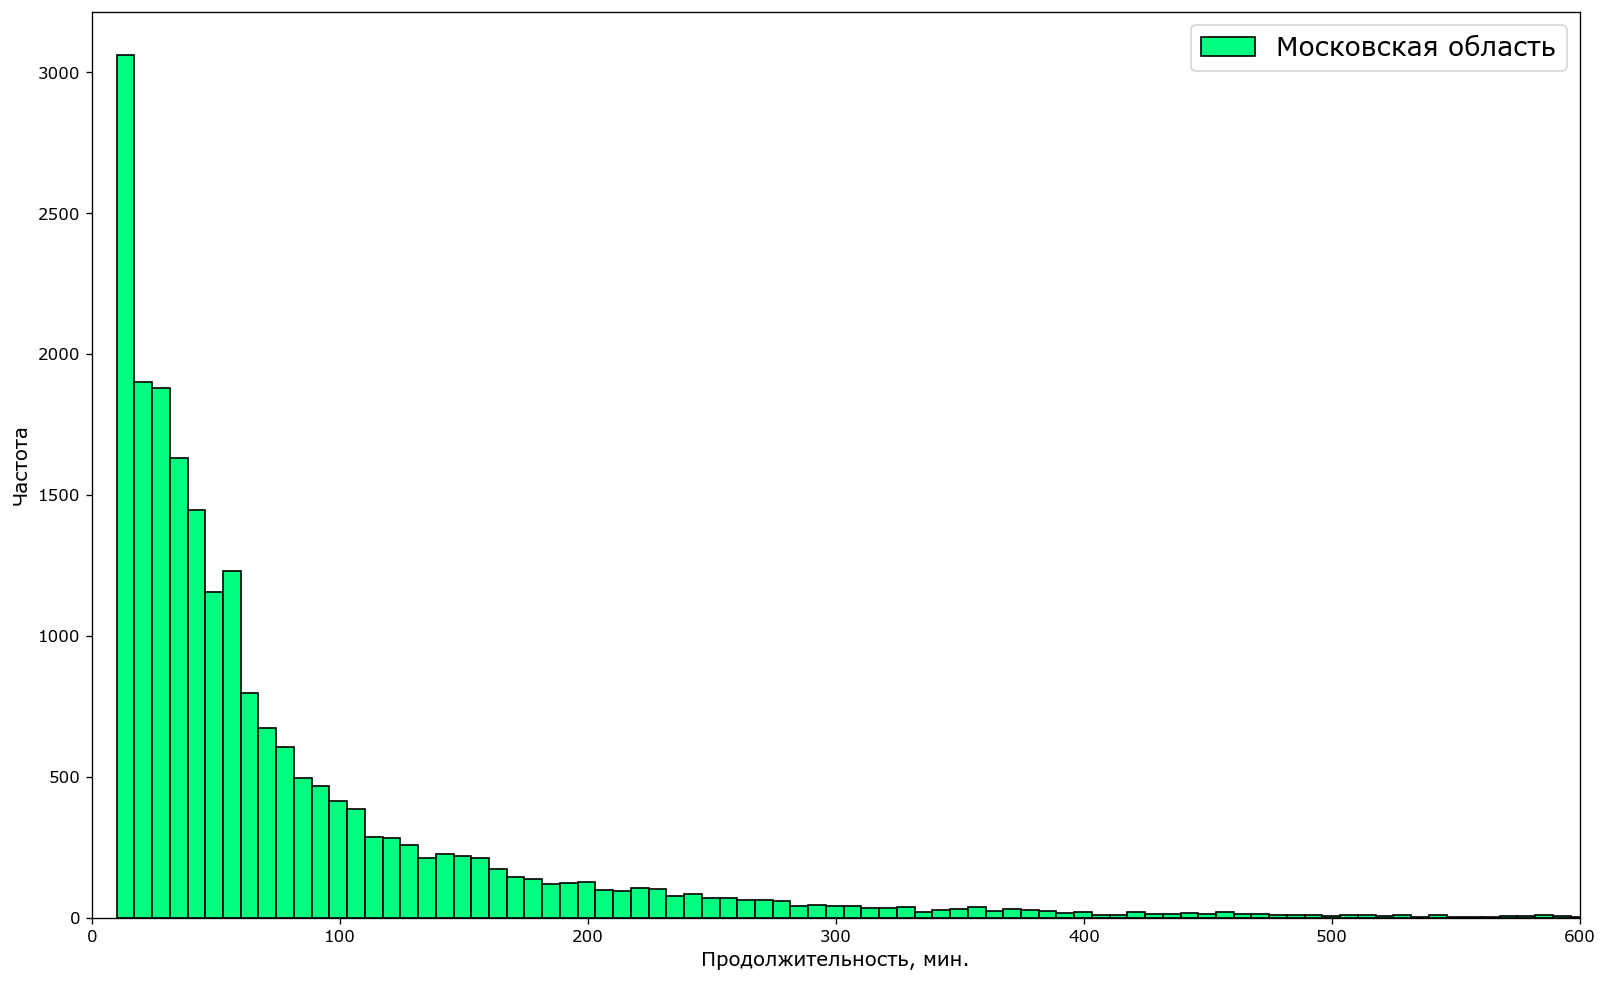

In [20]:
d2 = d1.copy()

h1 = d2.Busy[d2.F1==1146]
h2 = d2.Busy[d2.F1==1144]
h3 = d2.Busy[d2.F1==1176]
 
n = 800
plt.figure(figsize=(16, 10), dpi= 120, facecolor='w', edgecolor='gray')
plt.hist(h1, label='Московская область', color='SpringGreen', edgecolor='Black', bins = n)
plt.xlabel('Продолжительность, мин.', fontsize=12)
plt.ylabel('Частота', fontsize=12)
plt.xlim(0, 600)
plt.xscale('linear')  # logit log symlog linear
plt.legend(fontsize=16)
plt.savefig('picture/pic002.png', dpi=100, bbox_inches='tight') 
plt.show()

In [21]:
print('Количество пожаров в Московской области ликвидируемых за ограниченное время')
print(d2.Busy.loc[(d2.F1 == 1146) & (d2.Busy < 61)].value_counts().sum())
print('Среднее время занятости по регионам и объектам:')
print(d1.groupby(['F1','F12'])['Busy'].mean())

Количество пожаров в Московской области ликвидируемых за ограниченное время
12307
Среднее время занятости по регионам и объектам:
F1    F12
1144  1       66.427461
      2       49.666667
      3       30.333333
      8       50.011574
      9       20.000000
1146  1      125.859066
      2      353.113333
      3       32.494915
      8       57.117668
      9       29.833333
1176  1       63.073255
      2      104.830769
      3       33.464286
      8       42.020683
      9       32.250000
Name: Busy, dtype: float64


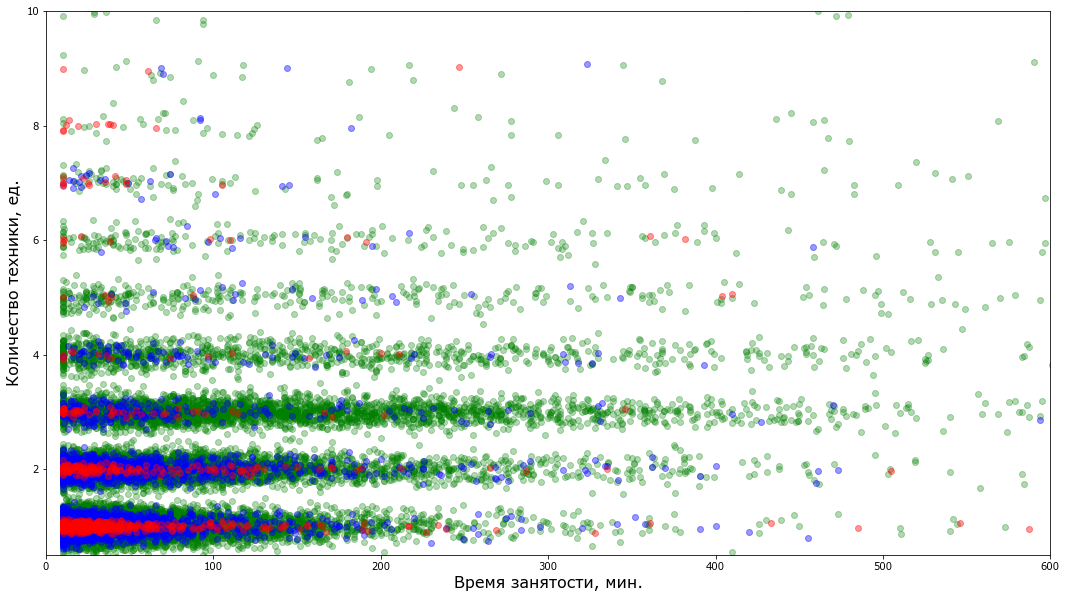

In [22]:
colrDict = {1144: 'red', 1146: 'green', 1176: 'blue'}

fig, ax = plt.subplots(figsize = (18,10))
Reg = 1146
ax.scatter(d1[d1.F1==Reg].Busy, f.jitter(d1[d1.F1==Reg].Car, 0.15), alpha=0.3, c=colrDict[Reg])
Reg = 1176
ax.scatter(d1[d1.F1==Reg].Busy, f.jitter(d1[d1.F1==Reg].Car, 0.12), alpha=0.4, c=colrDict[Reg])
Reg = 1144
ax.scatter(d1[d1.F1==Reg].Busy, f.jitter(d1[d1.F1==Reg].Car, 0.05), alpha=0.4, c=colrDict[Reg])


plt.xlim(0, 600)
plt.ylim(0.5, 10)
ax.set_xlabel('Время занятости, мин.', size=16)
ax.set_ylabel('Количество техники, ед.', size=16)
plt.xscale('linear')  # logit log symlog linear
plt.savefig('picture/pic001.png', dpi=100, bbox_inches='tight') 
plt.show()


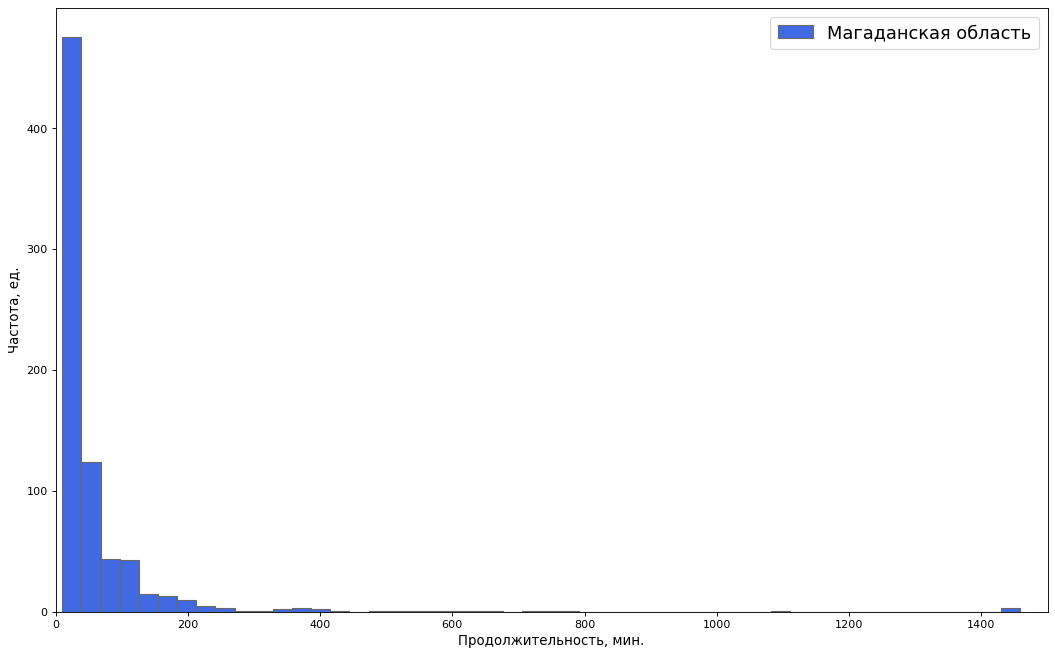

In [132]:
n = 50
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(h2, label='Магаданская область', color='RoyalBlue', edgecolor='DimGray', bins = n)
plt.xlabel('Продолжительность, мин.', fontsize=12)
plt.ylabel('Частота, ед.', fontsize=12)
plt.xlim(0, 1500)
plt.legend(fontsize=16)
plt.show()

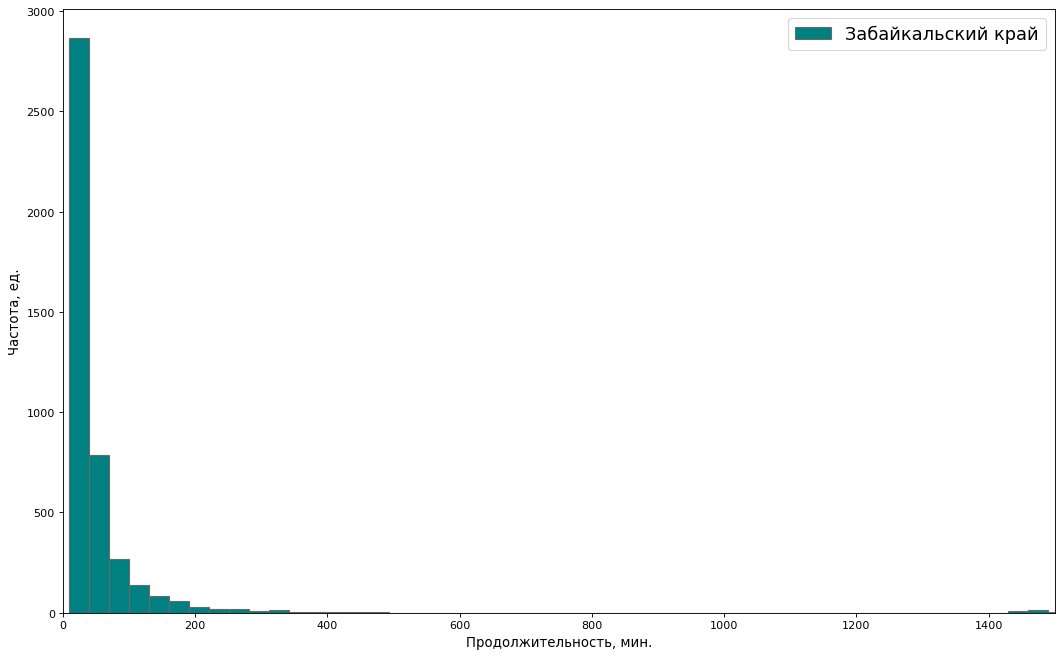

In [133]:
n = 50
plt.figure(figsize=(16, 10), dpi= 80, facecolor='w', edgecolor='k')
plt.hist(h3, label='Забайкальский край', color='Teal', edgecolor='DimGray', bins = n)
plt.xlabel('Продолжительность, мин.', fontsize=12)
plt.ylabel('Частота, ед.', fontsize=12)
plt.xlim(0, 1500)
plt.legend(fontsize=16)
plt.show()

In [194]:
print('Мода показателя Busy для субъектов:')
for i in d1.F1.unique():
    print(i, d1[d1.F1==i].Busy.mode()[0])

Мода показателя Busy для субъектов:
1144 11
1176 10
1146 20


In [23]:
print('Сводная статистика показателя Busy для субъектов:\n\
* рассматриваются только случаи Busy>9')
s, col = [], d1.F1.unique()
for i in col:
    s.append(d1.Busy.loc[((d1.F1==i) & (d1.Busy>9))].describe())
    
result = pd.concat(s, axis=1)
result.columns=col
result 

Сводная статистика показателя Busy для субъектов:
* рассматриваются только случаи Busy>9


,1144,1176,1146
count,877.000000,4992.000000,20520.000000
mean,55.955530,48.693109,85.316862
std,121.979157,115.615167,133.297512
min,10.000000,10.000000,10.000000
25%,13.000000,13.000000,25.000000
50%,25.000000,24.000000,47.500000
75%,48.000000,46.000000,96.000000
max,1458.000000,1520.000000,5730.000000


<h2>Удаление избыточных признаков и выбросов</h2>

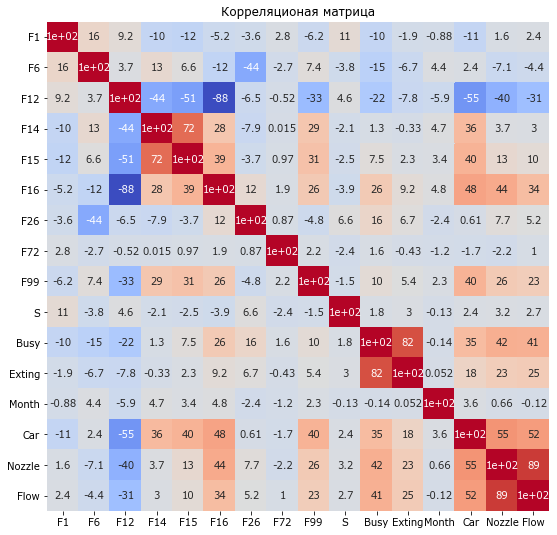

In [26]:
col = ['F1', 'F6', 'F12', 'F14', 'F15', 'F16', 'F26', 'F72', 'F99', 'S',
       'Busy', 'Exting', 'Month', 'Car', 'Nozzle', 'Flow']

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(cbar=False, annot=True,
            data=d1[col].corr()*100, cmap='coolwarm')
plt.title('Корреляционая матрица')
plt.savefig('picture/pic003.png', dpi=100, bbox_inches='tight') 
plt.show()

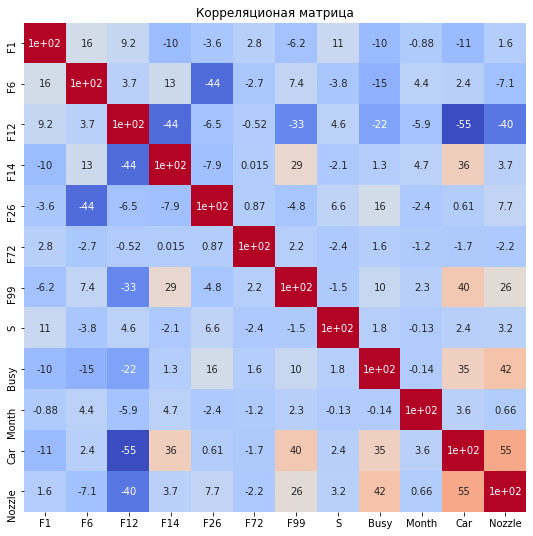

In [4]:
col = ['F1', 'F6', 'F12', 'F14', 'F26', 'F72', 'F99', 'S',
       'Busy', 'Month', 'Car', 'Nozzle']

fig, ax = plt.subplots(figsize=(9, 9))
sns.heatmap(cbar=False, annot=True,
            data=d1[col].corr()*100, cmap='coolwarm')
plt.title('Корреляционая матрица')
plt.savefig('picture/pic004.png', dpi=100, bbox_inches='tight') 
plt.show()

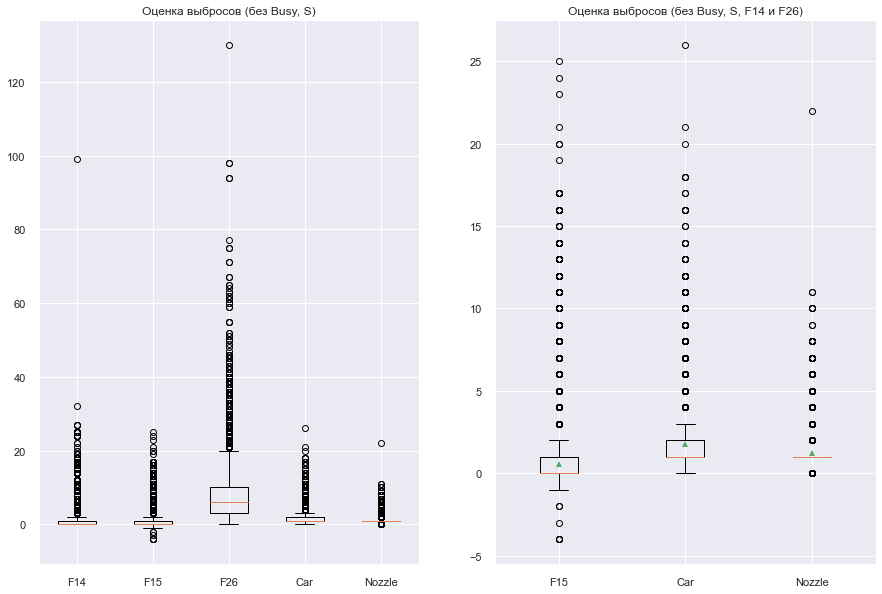

In [82]:
sns.set()
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# Все показатели
col = ['F14', 'F26', 'Car', 'Nozzle']  # ,'Busy','S'
sns.set()
ax[0].boxplot(d1[col], labels=col) # , showmeans=True
ax[0].set_title('Оценка выбросов (без Busy, S)')

# Без показателя Population
col = ['F15', 'Car', 'Nozzle'] 
ax[1].boxplot(d1[col], labels=col, showmeans=True)
ax[1].set_title('Оценка выбросов (без Busy, S, F14 и F26)')

plt.savefig('picture/pic005.png', dpi=100, bbox_inches='tight') 
plt.show()

<AxesSubplot:xlabel='F0'>

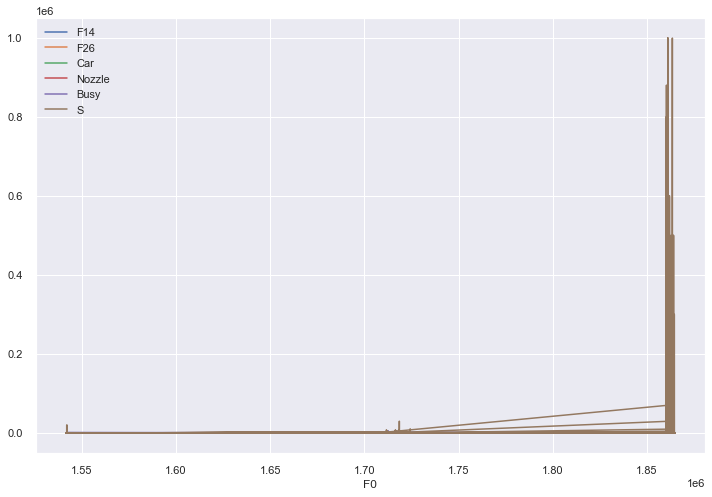

In [94]:
# col = ['F14', 'F15', 'F26', 'Car', 'Nozzle'] 
col = ['F14', 'F26', 'Car', 'Nozzle', 'Busy', 'S'] 
d1[col].plot(figsize=(12, 8))

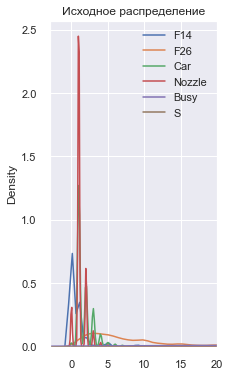

In [95]:
# plot original distribution plot
# fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 8))
sh = 3 # Ширина картинки

fig, ax1 = plt.subplots(figsize = (sh, 6))
ax1.set_title('Исходное распределение')
ax1.set_xlabel(' ')
plt.xlim(-3,20)

for i in col:
    sns.kdeplot(d1[i], ax=ax1)
plt.legend(col)
plt.savefig('picture/pic006-1.png', dpi=100, bbox_inches='tight') 
plt.show()

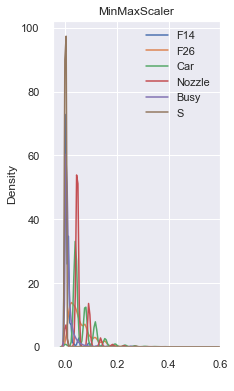

In [96]:
mm_scaler = preprocessing.MinMaxScaler()
df_mm = mm_scaler.fit_transform(d1[col])

df_mm = pd.DataFrame(df_mm, columns=col)

fig, ax1 = plt.subplots(figsize = (sh,6))
ax1.set_title('MinMaxScaler')
ax1.set_xlabel(' ')
plt.xlim(-0.05,0.6)
for i in col:
    sns.kdeplot(df_mm[i], ax=ax1)
plt.legend(col)
plt.savefig('picture/pic006-2.png', dpi=100, bbox_inches='tight') 
plt.show()

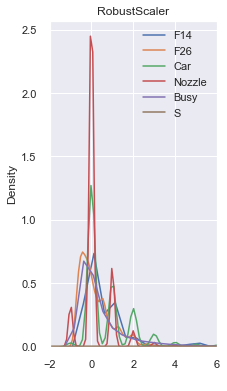

In [97]:
r_scaler = preprocessing.RobustScaler()
df_r = r_scaler.fit_transform(d1[col])

df_r = pd.DataFrame(df_r, columns=col)

fig, ax1 = plt.subplots(figsize = (sh,6))
ax1.set_title('RobustScaler')
ax1.set_xlabel(' ')
plt.xlim(-2,6)
for i in col:
    sns.kdeplot(df_r[i], ax=ax1)
plt.legend(col)
plt.savefig('picture/pic006-3.png', dpi=100, bbox_inches='tight') 
plt.show()

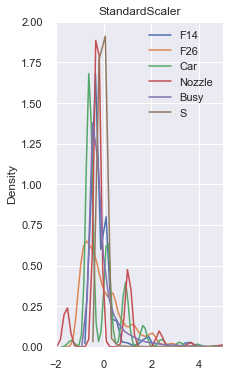

In [98]:
s_scaler = preprocessing.StandardScaler()
df_s = s_scaler.fit_transform(d1[col])

df_s = pd.DataFrame(df_s, columns=col)

fig, ax1 = plt.subplots(figsize = (sh,6))
ax1.set_title('StandardScaler')
ax1.set_xlabel(' ')
plt.xlim(-2,5)
for i in col:
    sns.kdeplot(df_s[i], ax=ax1)
plt.legend(col)
plt.savefig('picture/pic006-4.png', dpi=100, bbox_inches='tight') 
plt.show()

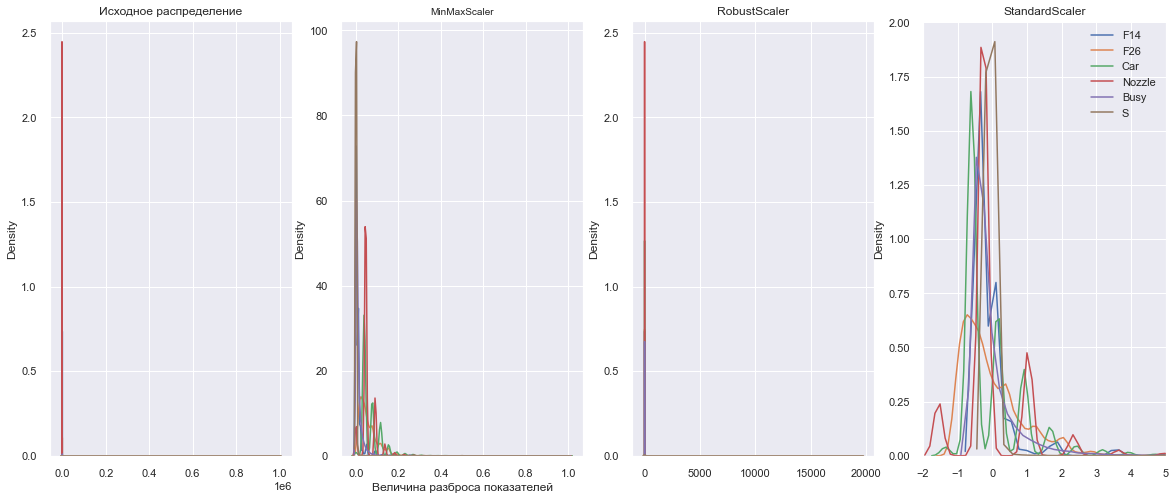

In [99]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(ncols=4, figsize=(20, 8))

#1
ax0.set_title('Исходное распределение')
ax0.set_xlabel(' ')
plt.xlim(-3,20)
for i in col:
    sns.kdeplot(d1[i], ax=ax0)
plt.legend(col) 

#2
ax1.set_title('MinMaxScaler', size=10)
ax1.set_xlabel('Величина разброса показателей')
plt.xlim(-0.05,0.6)
for i in col:
    sns.kdeplot(df_mm[i], ax=ax1)
plt.legend(col)

#3
ax2.set_title('RobustScaler')
ax2.set_xlabel(' ')
plt.xlim(-2,5)
for i in col:
    sns.kdeplot(df_r[i], ax=ax2)
plt.legend(col)

#4
ax3.set_title('StandardScaler')
ax3.set_xlabel(' ')
plt.xlim(-2,5)
for i in col:
    sns.kdeplot(df_s[i], ax=ax3)
plt.legend(col)

plt.show()

In [100]:
df_s.head()

,F14,F26,Car,Nozzle,Busy,S
0,0.047915,-0.565199,0.154469,1.037683,-0.010819,-0.054855
1,0.047915,-0.729140,-0.601377,1.037683,1.466915,-0.055721
2,0.047915,-0.893081,-0.601377,1.037683,0.571087,-0.053683
3,-0.389757,-0.893081,-0.601377,-0.260848,-0.401308,-0.055364
4,0.047915,-1.057022,1.666161,8.828870,-0.263488,-0.047725


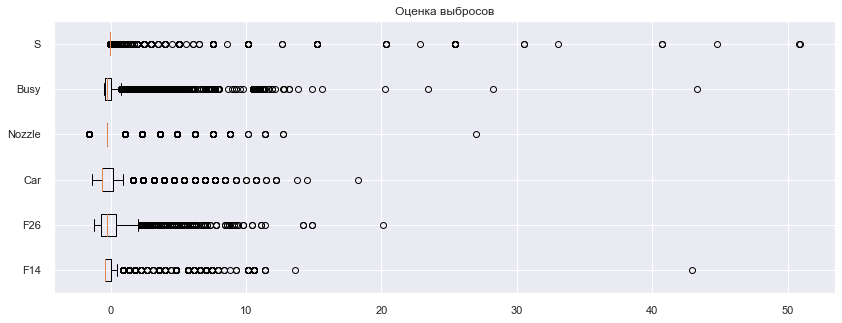

In [101]:
# Разброс показателей после нормализации
fig, ax = plt.subplots(1, 1, figsize=(14, 5))

# Все показатели
# col = ['F14', 'F15', 'F26', 'Car', 'Nozzle', 'Busy'] 
sns.set()
ax.boxplot(df_s[col], labels=col, vert=False) # , showmeans=True
ax.set_title('Оценка выбросов')

plt.savefig('picture/pic007.png', dpi=100, bbox_inches='tight') 
plt.show()

<h2>Создание обучающей выборки</h2>
<p>Выборка содержит категориальные показатели, которые необходимо преобразовать в числовые "фиктивные переменные"</p>

In [78]:
df_s.head()

,F14,F15,F26,Car,Nozzle,Busy
0,0.047915,0.355702,-0.565199,0.154469,1.037683,-0.010819
1,0.047915,0.355702,-0.729140,-0.601377,1.037683,1.466915
2,0.047915,0.355702,-0.893081,-0.601377,1.037683,0.571087
3,-0.389757,-0.456992,-0.893081,-0.601377,-0.260848,-0.401308
4,0.047915,0.355702,-1.057022,1.666161,8.828870,-0.263488


In [119]:
# col = ['F6', 'F12', 'F72', 'F99', 'S', 'Busy', 'Month', 'Car', 'Nozzle', 'Long']
 #['F6', 'F12', 'F72','F99', 'Month']
# Объединение преобразованных фреймов
d2 =  d1[['F6', 'F12', 'F72','F99', 'Month', 'Long']]
df_s['i1'] = d2.index
df_s = df_s.set_index('i1')
d3 = pd.concat([df_s, d2], axis=1)
d3.head()

,F14,F26,Car,Nozzle,Busy,S,F6,F12,F72,F99,Month,Long
1541656,0.047915,-0.565199,0.154469,1.037683,-0.010819,-0.054855,1,1,1,0,1,0
1541657,0.047915,-0.729140,-0.601377,1.037683,1.466915,-0.055721,1,1,1,0,1,0
1541658,0.047915,-0.893081,-0.601377,1.037683,0.571087,-0.053683,1,1,1,0,1,0
1541659,-0.389757,-0.893081,-0.601377,-0.260848,-0.401308,-0.055364,1,8,0,0,4,0
1859733,0.047915,-1.057022,1.666161,8.828870,-0.263488,-0.047725,1,1,8,1,9,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1864683,-0.389757,-0.729140,1.666161,-0.260848,-0.493188,-0.055823,1,3,0,0,12,0
1864684,-0.389757,-0.401258,0.154469,-0.260848,-0.508501,-0.055721,0,8,0,0,12,0
1864685,-0.389757,-0.401258,-0.601377,-0.260848,-0.447248,-0.045688,1,8,0,0,12,0
1864686,0.047915,-0.237317,0.154469,-0.260848,-0.294115,-0.055364,1,1,0,0,12,0


In [121]:
d3.columns

Index(['F14', 'F26', 'Car', 'Nozzle', 'Busy', 'S', 'F6', 'F12', 'F72', 'F99',
       'Month', 'Long'],
      dtype='object')

In [122]:
col = ['F14', 'F26', 'Car', 'Nozzle', 'Busy', 'S', 'F6', 'F12', 'F72', 'F99',
       'Month', 'Long']

df = pd.get_dummies(d3[col], columns=['F12','F72', 'Month'], drop_first=False)
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26389 entries, 1541656 to 1864687
Data columns (total 35 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   F14       26389 non-null  float64
 1   F26       26389 non-null  float64
 2   Car       26389 non-null  float64
 3   Nozzle    26389 non-null  float64
 4   Busy      26389 non-null  float64
 5   S         26389 non-null  float64
 6   F6        26389 non-null  int64  
 7   F99       26389 non-null  int64  
 8   Long      26389 non-null  int64  
 9   F12_1     26389 non-null  uint8  
 10  F12_2     26389 non-null  uint8  
 11  F12_3     26389 non-null  uint8  
 12  F12_8     26389 non-null  uint8  
 13  F12_9     26389 non-null  uint8  
 14  F72_0     26389 non-null  uint8  
 15  F72_1     26389 non-null  uint8  
 16  F72_2     26389 non-null  uint8  
 17  F72_3     26389 non-null  uint8  
 18  F72_4     26389 non-null  uint8  
 19  F72_5     26389 non-null  uint8  
 20  F72_6     26389 non-

<h2>Разделение набора</h2>
<p> Разделите выборку на обучающее и тестовое подмножество. 80% данных оставить на обучающее множество, 20% на тестовое.</p>
<p> Для получения адекватных результатов процесс обучения  и тестирования нужно проводить на  разных  наборах данных.  В противном случае невозможно узнать, насколько хорошо модель идентифицирует данные, которые она не получала раньше.  С  использованием методов  библиотеки  Scikit-learn,  в соответствии с заданием разобьем исходную выборку на две части размером 20% и 80%. Часть в 20%  данных предназначена для тестирования (чтобы  удалить элемент случайности, при сравнении  разных моделей будет использован параметр random_ state=42).</p>

In [123]:
df.columns

Index(['F14', 'F26', 'Car', 'Nozzle', 'Busy', 'S', 'F6', 'F99', 'Long',
       'F12_1', 'F12_2', 'F12_3', 'F12_8', 'F12_9', 'F72_0', 'F72_1', 'F72_2',
       'F72_3', 'F72_4', 'F72_5', 'F72_6', 'F72_8', 'F72_9', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12'],
      dtype='object')

In [124]:
from sklearn.model_selection import train_test_split
col = ['F14', 'F26', 'Car', 'Nozzle', 'Busy', 'S', 'F6', 'F99', 
       'F12_1', 'F12_2', 'F12_3', 'F12_8', 'F12_9', 'F72_0', 'F72_1', 'F72_2',
       'F72_3', 'F72_4', 'F72_5', 'F72_6', 'F72_8', 'F72_9', 'Month_1',
       'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7',
       'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12']

X, y = df[col], df['Long']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [125]:
# создать экземпляр модели
log_regression = LogisticRegression()

# подгонка модели с использованием обучающих данных
log_regression.fit(X_train, y_train)
'''
После выполнения строки кода возможно появление предупреждения:
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Это предупреждение об ограничении размеров памяти компьютера, поэтому хранится только 
несколько векторов, которые неявно представляют приближение градиентов.
'''
# используйте модель для прогнозирования тестовых данных
y_pred = log_regression.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


<h4>Диагности модели</h4>
<p>Создаем матрицу запутанности (confusion  matrix)</p>
<p> Матрица запутанности или неточностей (confusion  matrix)  позволяет увидеть правильные классификации, а также ложно позитивные и ложно негативные случаи. Может случиться так, что мы хотим оптимизировать в сторону ложно позитивных или ложно негативных случаев, а различные модели и параметры могут изменить это. Мы можем использовать библиотеку Scikit-learn для получения текстовой версии или библиотеку Yellowbrick  для построения графика. </p>

Из матрицы путаницы видно, что:
Истинно отрицательные прогнозы: 5226 или 99.0%;
Истинно положительные прогнозы: 9 или 0.2%;
Ложноотрицательные прогнозы: 25 или 0.5%;
Ложноположительные прогнозы: 18 или 0.3%;
Уровень достоверности модели (Accuracy) по истинным значениям: 99.37%
Уровень достоверности модели по тестовой выборке,
вычисленный c помощью встроенной функции score: 99.36%


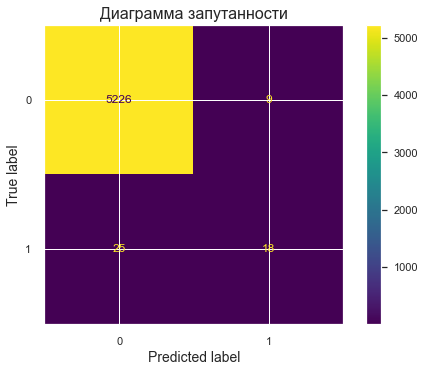

In [126]:
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()  # figsize=(5, 5)
mapping = {0: '<=50K', 1:  '>50K'}
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=log_regression.classes_)
plt.title('Диаграмма запутанности', size=16)
plt.xlabel('Истинный класс', size=14)
plt.ylabel('Прогонзируемый класс', size=14)
disp.plot(ax=ax)

cn = cnf_matrix.reshape(4)
p_cn = cn/cn.sum()
ac = log_regression.score(X_train, y_train)
print('Из матрицы путаницы видно, что:')

print(f'Истинно отрицательные прогнозы: {cn[0]} или {p_cn[0]:1.1%};')
print(f'Истинно положительные прогнозы: {cn[1]} или {p_cn[1]:1.1%};')
print(f'Ложноотрицательные прогнозы: {cn[2]} или {p_cn[2]:1.1%};')
print(f'Ложноположительные прогнозы: {cn[3]} или {p_cn[3]:1.1%};')
print(
    f'Уровень достоверности модели (Accuracy) по истинным значениям: {ac:1.2%}')
print(
    f'Уровень достоверности модели по тестовой выборке,\n\
вычисленный c помощью встроенной функции score: {log_regression.score(X_test, y_test):1.2%}')

In [127]:
log_regression.coef_

array([[-0.14639239,  0.06214455,  0.38754802,  0.72112541,  0.44009668,
        -0.06556358, -0.31874538,  1.10744521,  1.57116005,  1.773503  ,
        -0.21839547, -3.12115571, -0.00530354, -0.02558344, -0.12557626,
         1.27342355, -0.50737633,  0.09662031, -0.05368381, -0.23680181,
        -0.38721333, -0.03400056,  0.08727043,  0.1224459 , -0.12721531,
         0.1042962 , -0.4399572 ,  0.02824075,  0.02990043, -0.14147185,
         0.0918643 ,  0.41931609, -0.31622117,  0.14133974]])

detected multi-dimensional feature importances but stack=False, using mean to aggregate them.


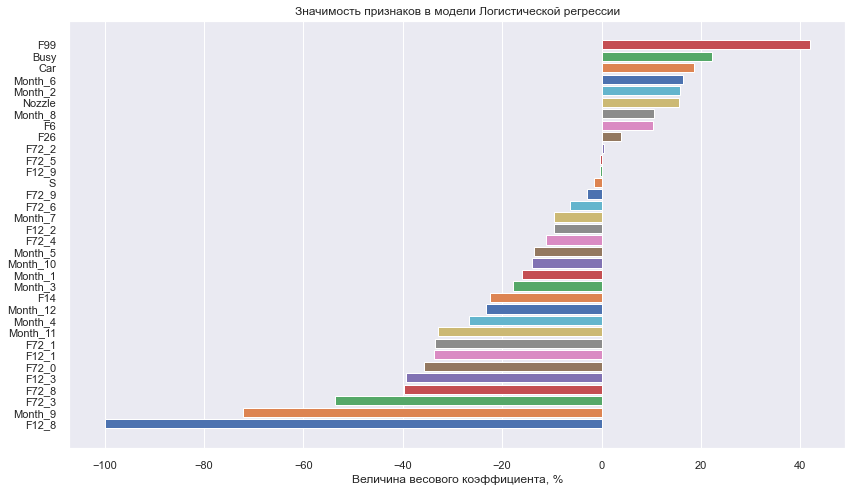

<AxesSubplot:title={'center':'Значимость признаков в модели Логистической регрессии'}, xlabel='Величина весового коэффициента, %'>

In [128]:
from yellowbrick.model_selection import FeatureImportances
fig, ax = plt.subplots(1, 1, figsize=(12, 7))

model = LogisticRegression(multi_class='auto', solver='liblinear')
viz = FeatureImportances(model, 
                         title='Значимость признаков в модели Логистической регрессии', 
                         xlabel='Величина весового коэффициента, %')

viz.fit(X_test, y_test)
viz.show()

In [137]:
# Список кодов неверно распознанных образцов
cl = []
for i,j in enumerate(y_test.index):
    if y_test[j] != y_pred[i]:
        cl.append(j)
        
# Загрузка данные с названиями объектов пожара и остальными показателями       
dd = pd.read_excel('R.xlsx', index_col='F0')

[1714173,
 1708285,
 1712219,
 1709700,
 1705379,
 1704002,
 1709692,
 1862476,
 1706217,
 1542309,
 1714742,
 1708966,
 1706968,
 1718237,
 1707250,
 1721727,
 1706486,
 1707631,
 1706214,
 1704773,
 1724230,
 1718305,
 1706922,
 1704070,
 1704699,
 1706460,
 1711038,
 1723275,
 1707982,
 1718260,
 1706748,
 1721761,
 1714188,
 1715922]

In [153]:
# Пожары ложно распознанные как ординарные
dd.loc[cl][dd.Long==1]

Boolean Series key will be reindexed to match DataFrame index.


,F1,F6,F12,F14,F15,F16,F26,F72,F99,F149,S,Busy,Exting,Month,Car,Nozzle,Flow,Long
F0,,,,,,,,,,,,,,,,,,
1714173,1146,0,1,2,1,5,17,0,0,Дом гр. Борунов В.Г.,180,226,148,6,6,6,21.0,1
1708285,1146,0,1,1,1,5,13,4,0,сарай с баней Ивановой О.В.,122,422,202,8,3,2,7.0,1
1712219,1146,1,2,1,1,3,4,8,0,"складское здание; ООО ПТП ""Стройматериалы - Ов...",450,400,151,5,6,5,17.5,1
1709700,1146,0,1,3,1,3,13,0,1,"Частный дом, пр-т Полынину А.Г.",126,367,209,2,4,3,14.0,1
1705379,1146,1,1,1,1,3,1,8,1,"неэксплуатируемое здание МУП ""Белоозерское ЖКХ""",200,499,91,7,5,3,27.0,1
1704002,1146,1,1,1,1,4,7,0,0,частный дом,130,170,122,11,3,3,10.5,1
1709692,1146,0,1,1,1,3,8,0,0,"4 хоз. постройки, Стакановой Е.В., Стебелевой ...",91,397,230,2,3,3,10.5,1
1862476,1176,0,1,1,1,5,39,4,0,Дом культуры,500,330,290,5,3,3,10.5,1
1706217,1146,1,1,1,1,5,1,2,0,сарай гр.Квасова В.В.,220,345,153,7,4,4,14.0,1


In [154]:
# Пожары ложно распознанные как затяжные
dd.loc[cl][dd.Long==0]

Boolean Series key will be reindexed to match DataFrame index.


,F1,F6,F12,F14,F15,F16,F26,F72,F99,F149,S,Busy,Exting,Month,Car,Nozzle,Flow,Long
F0,,,,,,,,,,,,,,,,,,
1714742,1146,0,1,2,1,5,12,0,1,Одноквартирный жилой дом (гр. Путилов В.В.),90,457,149,12,4,5,17.5,0
1708966,1146,0,1,1,1,5,8,1,0,бесхозяйные строения,30,912,52,4,7,8,38.5,0
1724230,1146,0,1,2,1,5,1,3,0,Дом,240,377,77,10,6,6,35.0,0
1706460,1146,0,1,1,1,3,18,2,1,КФХ Конно-спортивный манеж,40,224,60,11,6,4,14.0,0
1711038,1146,0,1,2,2,5,6,4,1,Одноквартирный жилой дом гр. Якушина М.М,300,813,189,9,4,4,14.0,0
1723275,1146,1,1,1,1,2,3,1,1,"Дом. Собственники:Филимонов,Хлуденев, Багрова.",80,165,32,1,5,6,24.5,0
1718260,1146,0,2,0,0,1,24,4,0,"резервуар № 15.4 для нефтепродуктов, ООО""ДНК""",56,202,67,9,12,7,98.0,0
1721761,1146,1,1,1,1,5,5,2,1,Частный жилой дом гр. Кузнецова К.Н.,30,443,133,3,6,5,17.5,0
1715922,1146,1,1,1,1,5,7,0,0,"Баня, вл. Порт В.В.",18,77,19,2,4,22,77.0,0
